### Классификация изображений художников разного стиля с использованием `PyTorch`

Импорт библиотек:

In [7]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
#import os
import torch.nn.functional as F
import matplotlib.pyplot as plt
from collections import defaultdict # to check distribution by classes
from sklearn.metrics import precision_recall_fscore_support # to calculate F1 score
from sklearn.model_selection import StratifiedShuffleSplit

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Определяем трансформацию изображений: отдельно для тренировочного набора с аугментацией данных и отдельно для тестового и валидационного.

In [2]:
# define default transormation

val_transform = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# randop crop
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
#     transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
    transforms.RandomGrayscale(p=0.2),
    transforms.RandomRotation(30),
    #transforms.GaussianNoise(0.1),

    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    #transforms.Normalize()
    #transforms.Normalize(mean, std)

])

Загрузка изображений, которые хранятся в директории `images` 

In [11]:
image_dataset = torchvision.datasets.ImageFolder('images', transform=val_transform)
print(image_dataset)

Dataset ImageFolder
    Number of datapoints: 1422
    Root location: images
    StandardTransform
Transform: Compose(
               Resize(size=64, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(64, 64))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


Разбиваем изображения на трейновый, валидационный и тестовый набор (70%, 20%, 10%) без стратификации. Оказалось, что это работает хуже чем со стратификацией с учетом размеров классов. Поэтому закоментировано

In [ ]:
# train_size = int(0.7 * len(image_dataset))
# val_size = int(0.2 * len(image_dataset))
# test_size = len(image_dataset) - train_size - val_size
# train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(image_dataset, [train_size, val_size, test_size])
# # realize data augmentation for train set
# train_dataset.dataset.transform = train_transform


In [ ]:
# print("Train set size: {:}, validation set size: {:}, test set size: {:}".format(train_size, val_size, test_size))

# print(train_size)
# print(val_size)
# print(test_size)
# print(train_dataset.dataset)

In [ ]:
# загрузка данных соответствующего размера
# train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
# val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)
# test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

Разбиваем изображения на трейновый, валидационный и тестовый набор с учетом размеров классов.

In [27]:
import time

# Code snippet 1
start_time = time.time()
labels = [image_dataset[i][1] for i in range(len(image_dataset))]
split = StratifiedShuffleSplit(n_splits=1, test_size=0.3)
for train_index, test_valid_index in split.split(range(len(image_dataset)), labels):
    train_dataset = torch.utils.data.Subset(image_dataset, train_index)
    test_valid_dataset = torch.utils.data.Subset(image_dataset, test_valid_index)
split = StratifiedShuffleSplit(n_splits=1, test_size=0.4)
for val_index, test_index in split.split(range(len(test_valid_dataset)), [test_valid_dataset[i][1] for i in range(len(test_valid_dataset))]):
    test_dataset = torch.utils.data.Subset(test_valid_dataset, test_index)
    val_dataset = torch.utils.data.Subset(test_valid_dataset, val_index)
print("Time taken by code snippet 1:", time.time() - start_time)

# Code snippet 2
start_time = time.time()
labels = [label for _, label in image_dataset]
split = StratifiedShuffleSplit(n_splits=1, test_size=0.3)
train_index, test_valid_index = next(split.split(range(len(image_dataset)), labels))
train_dataset = torch.utils.data.Subset(image_dataset, train_index)
test_valid_dataset = torch.utils.data.Subset(image_dataset, test_valid_index)
split = StratifiedShuffleSplit(n_splits=1, test_size=0.4)
val_index, test_index = next(split.split(range(len(test_valid_dataset)), [label for _, label in test_valid_dataset]))
test_dataset = torch.utils.data.Subset(test_valid_dataset, test_index)
val_dataset = torch.utils.data.Subset(test_valid_dataset, val_index)
print("Time taken by code snippet 2:", time.time() - start_time)


Time taken by code snippet 1: 4.989258050918579
Time taken by code snippet 2: 4.463263273239136


In [43]:
# labels = [label for _, label in image_dataset]

# print(len(labels))
# split = StratifiedShuffleSplit(n_splits=1, test_size=0.3)
# print(split.train_size)

# print(train_index)
print(len(test_valid_index))
print(val_index)
print(test_index)

427
[315 326 283 391  49 247  99 397 121  27 266  44 354 248 207 126  51 141
 163 278  22 252 125 213 284  86 417 363  38 269  17  35 367 353 412  55
 111 231  24 362 337 244  16 227 157 268 336 309 379 394 387 419  62 423
 100 288 162 342 319  97 258 358 347   6 384 115 416 253 348  40  73 381
 371 113 338 302 286  93  54 155 378 277 108 316 120  58 243  82 216 218
   7 386 153 138  72 314 270 160 146  10  77 402  70 324 191 383  14 147
  48  45 260 230 142 221 296  30 242 289 110   3 272 237 246 123 374 343
 421  41   9 151 405 377  37 145 170 293 306  63 195 317 407 181 196   2
 194  25 116 370 201 208 368 217  69 127 214 220 325 128 107 330  67 135
 251  66 398 222 192 346 174 276  23  60 424 307 271 273 118 261  84 310
 224 369 408  50  18 117 413 411   0 139 255 205 148 275 401 124 168 335
 211  21 389 140 189 103 239 313 299 234  80  13 133 131 380 328 188  75
 372 323 198 332 226   5 292   1 250  85 331 164 206 232 167 340 390 101
  12 406 176  20 422 274  52 418 308 143  28 33

In [26]:
from sklearn.model_selection import StratifiedShuffleSplit

# Get the labels for each image
# labels = [image_dataset[i][1] for i in range(len(image_dataset))]
labels = [label for _, label in image_dataset]

# Create the stratified shuffle split object
split = StratifiedShuffleSplit(n_splits=1, test_size=0.3)

# Split the indices of the images into train and validation-test sets
train_index, test_valid_index = next(split.split(range(len(image_dataset)), labels))
train_dataset = torch.utils.data.Subset(image_dataset, train_index)
test_valid_dataset = torch.utils.data.Subset(image_dataset, test_valid_index)

# for train_index, test_valid_index in split.split(range(len(image_dataset)), labels):
#     train_dataset = torch.utils.data.Subset(image_dataset, train_index)
#     test_valid_dataset = torch.utils.data.Subset(image_dataset, test_valid_index)

# Create a second stratified shuffle split object for the train set
split = StratifiedShuffleSplit(n_splits=1, test_size=0.4)
val_index, test_index = next(split.split(range(len(test_valid_dataset)), [label for _, label in test_valid_dataset]))
test_dataset = torch.utils.data.Subset(test_valid_dataset, test_index)
val_dataset = torch.utils.data.Subset(test_valid_dataset, val_index)

# Split the indices of the train set into train and validation sets
# for val_index, test_index in split.split(range(len(test_valid_dataset)), [test_valid_dataset[i][1] for i in range(len(test_valid_dataset))]):
#     test_dataset = torch.utils.data.Subset(test_valid_dataset, test_index)
#     val_dataset = torch.utils.data.Subset(test_valid_dataset, val_index)


In [36]:
# загрузка данных соответствующего размера
train_dataset.dataset.transform = train_transform
print(train_dataset.dataset)
batch_size = 32
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Dataset ImageFolder
    Number of datapoints: 1422
    Root location: images
    StandardTransform
Transform: Compose(
               Resize(size=64, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(64, 64))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


In [48]:
print(train_dataset.dataset.transform)
print(val_dataset.indices)
# print(val_dataset.dataset.transform)
# print(test_dataloader.dataset.transform)
# print(test_dataset.dataset.transform)

Compose(
    RandomHorizontalFlip(p=0.5)
    RandomVerticalFlip(p=0.5)
    RandomGrayscale(p=0.2)
    RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
    Resize(size=64, interpolation=bilinear, max_size=None, antialias=None)
    CenterCrop(size=(64, 64))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
[315 326 283 391  49 247  99 397 121  27 266  44 354 248 207 126  51 141
 163 278  22 252 125 213 284  86 417 363  38 269  17  35 367 353 412  55
 111 231  24 362 337 244  16 227 157 268 336 309 379 394 387 419  62 423
 100 288 162 342 319  97 258 358 347   6 384 115 416 253 348  40  73 381
 371 113 338 302 286  93  54 155 378 277 108 316 120  58 243  82 216 218
   7 386 153 138  72 314 270 160 146  10  77 402  70 324 191 383  14 147
  48  45 260 230 142 221 296  30 242 289 110   3 272 237 246 123 374 343
 421  41   9 151 405 377  37 145 170 293 306  63 195 317 407 181 196   2
 194  25 116 370 201 208 368 217  69 127

In [22]:
print("Train set size: {:}, validation set size: {:}, test set size: {:}".format(train_index.size, val_index.size, test_index.size))

Train set size: 995, validation set size: 170, test set size: 257


Проверим результат разбиения по классам

In [50]:
def count_classes(dataloader):
    labels_count = defaultdict(int)
    for i, data in enumerate(dataloader, 0):
        inputs, labels = data
        for label in labels:
            labels_count[label.item()] += 1
    return(labels_count)

data = {'Train set': count_classes(train_dataloader),
        'Validation set': count_classes(val_dataloader),
        'Test set': count_classes(test_dataloader)}
print(data)

{'Train set': defaultdict(<class 'int'>, {3: 142, 7: 97, 1: 255, 5: 82, 2: 168, 0: 46, 6: 52, 4: 153}), 'Validation set': defaultdict(<class 'int'>, {4: 39, 2: 43, 1: 66, 5: 21, 3: 37, 6: 14, 0: 11, 7: 25}), 'Test set': defaultdict(<class 'int'>, {6: 9, 3: 24, 4: 26, 2: 29, 1: 44, 7: 17, 5: 14, 0: 8})}


In [52]:
sorted_data = {group: dict(sorted(data[group].items())) for group in data.keys()}

for i, group in enumerate(sorted_data.keys()):
    print(group)
    print(list(sorted_data[group].keys()))
    print(list(sorted_data[group].values()))
    
# for i, group in enumerate(data.keys()):
#     print(group)
#     keys = list(data[group].keys())
#     print(keys)
#     print(list(data[group].values()))

Train set
[0, 1, 2, 3, 4, 5, 6, 7]
[46, 255, 168, 142, 153, 82, 52, 97]
Validation set
[0, 1, 2, 3, 4, 5, 6, 7]
[11, 66, 43, 37, 39, 21, 14, 25]
Test set
[0, 1, 2, 3, 4, 5, 6, 7]
[8, 44, 29, 24, 26, 14, 9, 17]


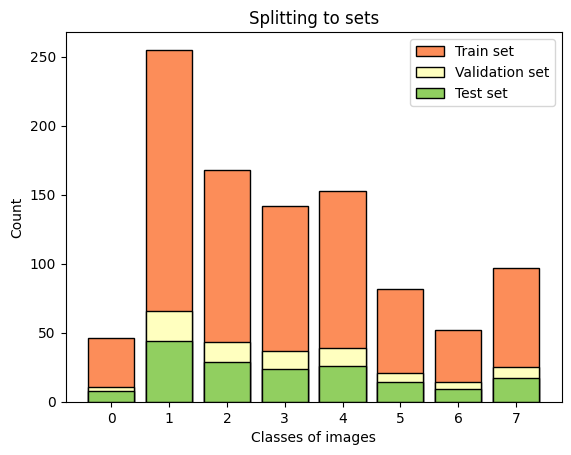

In [56]:
colors = ['#fc8d59', '#ffffbf', '#91cf60']

for i, group in enumerate(data.keys()):
    keys = list(data[group].keys())
    values = list(data[group].values())
    plt.bar(keys, values, edgecolor='black', color=colors[i], label=group)

plt.xlabel('Classes of images')
plt.ylabel('Count')
plt.title('Splitting to sets')
plt.legend()
plt.show()

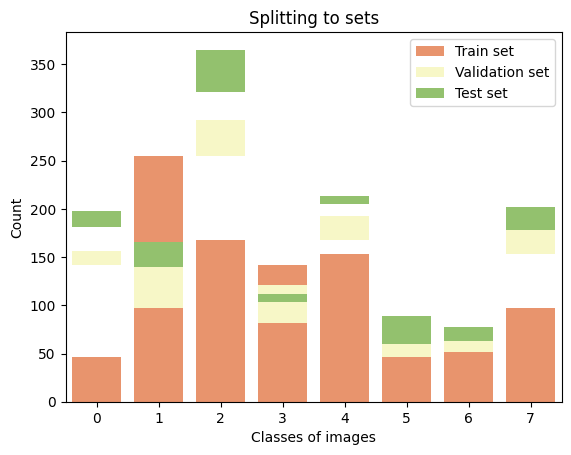

In [60]:
import seaborn as sns
# import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
keys = list(data['Train set'].keys())
train_values = list(data['Train set'].values())
val_values = list(data['Validation set'].values())
test_values = list(data['Test set'].values())

df = pd.DataFrame({'keys': keys, 
                   'Train set': train_values, 
                   'Validation set': val_values, 
                   'Test set': test_values})

sns.barplot(x='keys', y='Train set', data=df, color='#fc8d59', label='Train set')
sns.barplot(x='keys', y='Validation set', data=df, color='#ffffbf', label='Validation set', bottom=train_values)
sns.barplot(x='keys', y='Test set', data=df, color='#91cf60', label='Test set', bottom=np.array(train_values) + np.array(val_values))

plt.xlabel('Classes of images')
plt.ylabel('Count')
plt.title('Splitting to sets')
plt.legend()
plt.show()

plt.show()


Определяем модель для классификации изображений: resnet с 18 слоями, задаем на полносвязном уровне количество наших классов 

In [ ]:
model = torchvision.models.resnet18(weights=True)
#model = torchvision.models.resnet50(weights=True)

model.fc = nn.Linear(512, len(image_dataset.classes))
# model.fc.register_forward_hook(lambda m, inp, out: F.dropout(out, p=0.2, training=m.training))
#model.fc.register_forward_hook(lambda m, inp, out: nn.Softmax(out))
#model.fc = nn.Sequential(
 #   nn.Linear(512, len(image_dataset.classes)),
  #  nn.Softmax())
#model.fc.register_forward_hook(lambda m, inp, out: F.dropout(out, p=0.2, training=m.training))


In [ ]:
# from torchvision.models.feature_extraction import get_graph_node_names
# from torchvision.models import resnet50

# train_nodes, eval_nodes = get_graph_node_names(resnet50())
# print(train_nodes)
# print(eval_nodes)

Выбираю функцию ошибки CrossEntropyLoss, поскольку у нас задача классификации нескольких классов. Стохастический градиентный спуск показал самый лучший результат в этой задаче


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# optimizer = optim.Adam(model.parameters())
# optimizer = optim.RMSprop(model.parameters()) # this optimizer functioned really bad

In [ ]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
f1_scores = []

In [ ]:
print(val_dataloader.dataset)

Задаем функцию для проверки валидационного и тестого сета, чтобы не дублировать код

In [ ]:
# import torch
# import numpy as np
# from sklearn.metrics import precision_recall_fscore_support

def validate(curr_model, dataloader, criterion):
    with torch.no_grad():
        running_loss = 0.0
        total = 0
        confusion_matrix = torch.zeros(len(image_dataset.classes), len(image_dataset.classes), dtype=torch.int64)
        true_labels = []
        pred_labels = []

        for i, data in enumerate(dataloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = curr_model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, preds = torch.max(outputs, dim=1)
            total += labels.size(0)

            true_labels.extend(labels.tolist())
            pred_labels.extend(preds.tolist())

            for t, p in zip(labels, preds):
                confusion_matrix[t, p] += 1

        val_loss = running_loss / len(dataloader)
        precision, recall, f1_score, _ = precision_recall_fscore_support(true_labels, pred_labels, average='weighted', zero_division=0)
        precision_macro, recall_macro, f1_score_macro, _ = precision_recall_fscore_support(true_labels, pred_labels, average='macro', zero_division=0)
        print(f1_score)
#         results = {
#             "Loss": val_loss,
#             "Confusion Matrix": confusion_matrix,
#             "Precision": precision,
#             "Recall": recall,
#             "F1-Score": f1_score
#             "Macro Precision": precision_macro,
#             "Macro Recall": recall_macro,
#             "Macro F1-Score": f1_score_macro,
#         }
    return val_loss, precision, f1_score



In [ ]:
# f1_score

In [ ]:
num_epochs = 50

best_accuracy = 0
best_loss = float('inf')
best_epoch = 0
best_f1_score = 0
f1_score = 0
for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(train_dataloader, 0):
        inputs, labels = data
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Record the loss and accuracy
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    # Calculate the average loss and accuracy for the epoch
    train_loss = running_loss / len(train_dataloader)
    train_accuracy = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validate the model
    val_loss, val_accuracy, f1_score = validate(model, val_dataloader, criterion)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    f1_scores.append(f1_score)

    print("Epoch {}/{} - Train Loss: {:.4f} - Train Accuracy: {:.2f}% - Val Loss: {:.4f} - Val Accuracy: {:.2f}%, f1_score {:}".format(
        epoch + 1, num_epochs, train_loss, train_accuracy, val_loss, val_accuracy, f1_score))
    if f1_score > best_f1_score:
        best_f1_score = f1_score
#         best_loss = val_loss
        best_epoch = epoch
        torch.save(model.state_dict(), 'best_model_f1.pt')

In [ ]:
print(f1_scores)
best_f1_score

In [ ]:
epochs = range(1, num_epochs + 1)
plt.subplot(2, 1, 1)
plt.plot(epochs, train_losses, 'b', label='Train Loss')
plt.plot(epochs, val_losses, 'r', label='Validation Loss')
plt.title('Train and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(range(1, num_epochs+1))
plt.legend()
plt.axvline(x = best_epoch+1, linestyle = '-')
plt.show()

plt.subplot(2, 1, 2)
plt.plot(epochs, train_accuracies, 'b', label='Train Accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation Accuracy')
plt.title('Train and Validation Accuracy')
plt.xticks(range(1, num_epochs+1))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.axvline(x = best_epoch+1, linestyle = '-')
plt.show()


#plt.plt(train_losses, val_losses)

In [ ]:
# best_model = models.resnet.ResNet(...)
model.load_state_dict(torch.load('best_model_f1.pt'))
# print(model)
test_loss, test_accuracy, test_f1_score = validate(model, test_dataloader, criterion)
print(best_epoch+1)
print("Test Loss: {:.4f}, Test Accuracy: {:.2f}% in the epoch {:} F1 {:}".format(test_loss, test_accuracy, best_epoch+1, test_f1_score))

In [ ]:
# print(model)
# type(best_model)
# type(model)
# print(best_model.__class_)

Почему использовали F1 score взвешенный

In [ ]:
# Initialize the confusion matrix

confusion_matrix = torch.zeros(len(image_dataset.classes), len(image_dataset.classes), dtype=torch.int64)

# Initialize the lists to store the true labels and predicted labels for the test set
true_labels = []
pred_labels = []

# Evaluation mode
model.eval()

# Set the gradient computation to be off
with torch.no_grad():
    # Iterate over the test data
    for inputs, labels in test_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, dim=1)
        
        # Append the true labels and predicted labels to the lists
        true_labels.extend(labels.tolist())
        pred_labels.extend(preds.tolist())
        
        # Increment the count in the corresponding cells of the confusion matrix
        for t, p in zip(labels, preds):
            confusion_matrix[t, p] += 1

# Compute the precision, recall and f1-score
precision, recall, f1_score, _ = precision_recall_fscore_support(true_labels, pred_labels, average='weighted')
precision_macro, recall_macro, f1_score_macro, _ = precision_recall_fscore_support(true_labels, pred_labels, average='macro')

# Print the test loss, test accuracy and f1-score
print("Weighted Test Loss: {:.4f} - Test Accuracy: {:.2f}% - Test F1-Score: {:.2f}".format(test_loss, test_accuracy, f1_score))
print("Macro Test Loss: {:.4f} - Test Accuracy: {:.2f}% - Test F1-Score: {:.2f}".format(test_loss, test_accuracy, f1_score_macro))

In [ ]:
confusion_matrix

In [ ]:
print(precision)
print(recall)

In [ ]:
print(train_losses)
print(train_accuracies)
print(val_losses)
print(val_accuracies)